In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
#폴더 이름에서 레이블 따오기
import os
driver_image_path = '/content/drive/MyDrive/driver_motion/imgs/train'
class_names = sorted(os.listdir(driver_image_path))
# if '.ipynb_checkpoints' in class_names:
#   class_names.remove('.ipynb_checkpoints')
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [3]:
#한개의 이미지를 가져와서 이미지 크기 확인하기
import cv2
imageee = cv2.imread('/content/drive/MyDrive/driver_motion/imgs/train/c0/img_100026.jpg')
imageee.shape

(240, 320, 3)

In [4]:
#OpenCV로 불러온 이미지의 파일 경로를 images 리스트에 넣어주고 인코딩한 레이블을 각 이미지에 할당해주기
img_size = (200 , 200, 3)

images = []
labels = []

for class_name in class_names:
  images_files_folder_name = os.path.join(driver_image_path , class_name)
  if os.path.isdir(images_files_folder_name):
    for image_name in os.listdir(images_files_folder_name):
      if image_name.endswith('.jpg'):
        image_full_path = os.path.join(images_files_folder_name , image_name)
        #print(image_full_path)
        img = cv2.imread(image_full_path)
        img_cvt = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

        images.append(img_cvt)

        label = class_names.index(class_name)
        labels.append(label)

print(f"Total images : {len(images)} , Total labels : {len(labels)}")



Total images : 17471 , Total labels : 17471


In [ ]:
#images , labels 리스트를 X_train 과 X_val로 나눠주기
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , labels , test_size = 0.2)

In [ ]:
#데이터 증강 해주기
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.05),             #랜덤 회전
    tf.keras.layers.RandomFlip(mode='horizontal'),           #랜덤 수평 플립
    tf.keras.layers.RandomContrast(factor=0.2),              #랜덤 대비 조정
])

In [ ]:
#이미지 사이즈 리사이즈 및 텐서플로 데이터셋 만들기
import tensorflow as tf

def preprocessing_image(image , label):
  image = tf.image.resize(image , img_size[:2])
  return image , label

def augment_image(image , label):
  image = data_augmentation(image)
  return image , label
def create_tensorflow_dataset(images ,labels , batch_size = 32 , buffer_size = 1000 , augment = False):
  dataset = tf.data.Dataset.from_tensor_slices((images , labels))
  dataset = dataset.map(preprocessing_image , num_parallel_calls = tf.data.AUTOTUNE)
  if augment:
    dataset = dataset.map(augment_image , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
  return dataset

In [ ]:
#Train_dataset 및 Val_dataset 데이터셋만들어주기
train_dataset = create_tensorflow_dataset(X_train , y_train , batch_size = 32 , buffer_size = len(X_train) , augment = True)
val_dataset = create_tensorflow_dataset(X_val , y_val , batch_size = 32 , buffer_size = len(X_val) , augment = False)

In [ ]:
#CNN 모델 아키텍처 구현
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = img_size),
    tf.keras.layers.Rescaling(scale = 1. / 255),
    tf.keras.layers.Conv2D(64 , kernel_size = 3, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64 , kernel_size = 3, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Conv2D(128 , kernel_size = 2, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128 , kernel_size = 2, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Conv2D(256 , kernel_size = 2, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(256 , kernel_size = 2, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Conv2D(512 , kernel_size = 2, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(512 , kernel_size = 2, padding = 'same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256 , activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128 , activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64 , activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(class_names) , activation = 'softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 10)
history = model.fit(train_dataset , epochs = 35 , validation_data = val_dataset , callbacks = [early_stopping_cb])

Epoch 1/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 223s 392ms/step - accuracy: 0.1297 - loss: 4.5798 - val_accuracy: 0.1974 - val_loss: 2.2326
Epoch 2/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 153s 309ms/step - accuracy: 0.1573 - loss: 2.2215 - val_accuracy: 0.2315 - val_loss: 2.0547
Epoch 3/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 152s 307ms/step - accuracy: 0.2222 - loss: 2.0905 - val_accuracy: 0.3697 - val_loss: 1.8789
Epoch 4/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 152s 307ms/step - accuracy: 0.4475 - loss: 1.4817 - val_accuracy: 0.5176 - val_loss: 1.2692
Epoch 5/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 152s 307ms/step - accuracy: 0.5915 - loss: 1.1048 - val_accuracy: 0.6933 - val_loss: 0.8612
Epoch 6/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 153s 307ms/step - accuracy: 0.7097 - loss: 0.8044 - val_accuracy: 0.8472 - val_loss: 0.4611
Epoch 7/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 153s 307ms/step - accuracy: 0.7938 - loss: 0.6070 - val_accuracy: 0.9090 - val_loss: 0.3014
Epoch 8/35
437/437 ━━━━━━━━━━━━━━━━━━━━ 153s 307ms/step - accuracy: 0.8362 -

In [ ]:
history = history.history

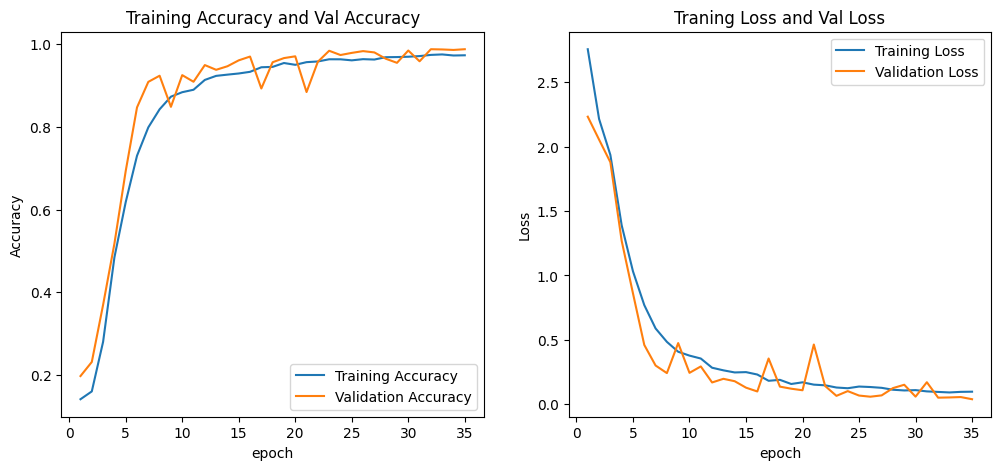

In [ ]:
#Matplotlib로 Accuracy 및 Loss 그려보기
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epoch = range(1 , len(loss) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize  = (12 , 5))
plt.subplot(121)
plt.plot(epoch , accuracy , label = 'Training Accuracy')
plt.plot(epoch , val_accuracy , label = 'Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy and Val Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epoch , loss , label = 'Training Loss')
plt.plot(epoch , val_loss , label = 'Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Traning Loss and Val Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


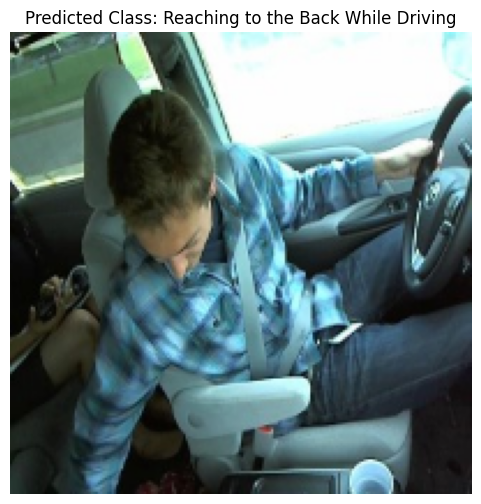

Predicted probabilities (in %): [[7.7101733e-15 1.7989382e-20 5.8336101e-16 6.7475832e-19 4.6791921e-20
  9.6262354e-13 1.8525697e-20 1.0000000e+02 5.6439540e-06 1.4188489e-13]]


In [7]:
#훈련한 모델로 test 파일에 있는 이미지 한개 가져와서 잘 분류하는지 확인해보기
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#테스트 이미지 경로
test_image_path = '/content/drive/MyDrive/driver_motion/imgs/test/img_33166.jpg'
#이미지 로드 및 전처리
def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image 에러...")
    img_resized = cv2.resize(img, target_size[:2])
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_array = np.asarray(img_rgb)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


target_size = (200, 200)
test_img_array = load_and_preprocess_image(test_image_path, target_size)

#예측 수행
predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

#클래스 이름 정의
class_names = {
    0: 'Safe Driving',
    1: 'Left-Handed Phone Use While Driving',
    2: 'Right-Handed Calling While Driving',
    3: 'Right-Handed Phone Use While Driving',
    4: 'Left-Handed Calling While Driving',
    5: 'Navigation Use While Driving',
    6: 'Drinking Coffee While Driving',
    7: 'Reaching to the Back While Driving',
    8: 'Grooming While Driving',
    9: 'Talking to Passenger While Driving'
}

#예측된 클래스 이름 가져오기
predicted_class_name = class_names[predicted_class]

plt.figure(figsize=(6, 6))
plt.imshow(test_img_array[0].astype('uint8'))
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()
print(f'Predicted probabilities (in %): {predictions * 100}')

In [ ]:
model.save('/content/drive/MyDrive/driver_motion/makkee_tensorflow_dataset_driver_motion.keras')

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200, 200, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 128)       │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 128)       │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 100, 100, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 50, 50, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 256)         │         262,4

 Total params: 63,079,328 (240.63 MB)

 Trainable params: 21,025,162 (80.20 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 42,050,326 (160.41 MB)